In [89]:
import cv2
from PIL import Image
import numpy as np
import glob
import pandas as pd
from pathlib import Path
import os
from keras.models import Sequential, Model, load_model
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, Activation
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import Callback, EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
from keras import backend as K
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

In [124]:
print(f'GPU and CUDA : {tf.test.is_gpu_available(cuda_only=False, min_cuda_compute_capability=None)}')

GPU and CUDA : True


In [90]:
print(os.listdir("chest_xray/chest_xray/"))

['.DS_Store', 'test', 'train', 'val']


In [91]:
data_dir = Path("chest_xray/chest_xray/")
train_dir = data_dir/'train'
val_dir = data_dir/'val'
test_dir = data_dir/'test'

In [92]:
def load_train():
    normal_cases_dir = train_dir/'NORMAL'
    pneumonia_cases_dir = train_dir/'PNEUMONIA'
    normal_cases = normal_cases_dir.glob('*.jpeg')
    pneumonia_cases = pneumonia_cases_dir.glob('*.jpeg')
    train_data = []
    train_label = []
    for img in normal_cases:
        train_data.append(img)
        train_label.append('NORMAL')
    for img in pneumonia_cases:
        train_data.append(img)
        train_label.append('PNEUMONIA')
    df = pd.DataFrame(train_data)
    df.columns=['images']
    df['labels'] = train_label
    df = df.sample(frac=1).reset_index(drop=True)
    return df

In [93]:
train_data = load_train()
train_data.shape

(5216, 2)

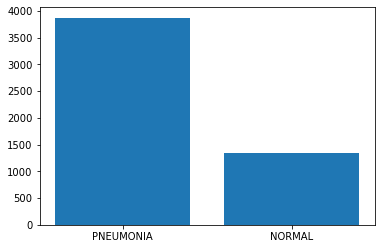

In [94]:
plt.bar(train_data['labels'].value_counts().index, train_data['labels'].value_counts().values)
plt.show()

In [95]:
def plot(image_batch, label_batch):
    plt.figure(figsize=(10,5))
    for i in range(10):
        ax = plt.subplot(2,5,i+1)
        img = cv2.imread(str(image_batch[i]))
        img = cv2.resize(img, (224,224))
        plt.imshow(img)
        plt.title(label_batch[i])
        plt.axis('off')

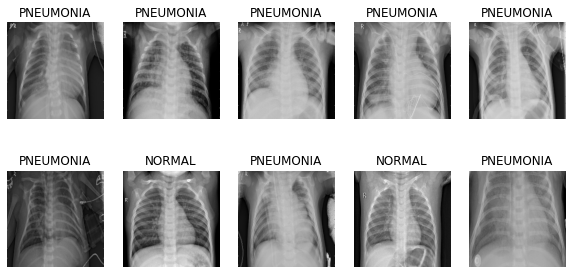

In [96]:
plot(train_data['images'], train_data['labels'])

In [97]:
def prepare_and_load(isval=True): # True => Validation Data, False => Test Data
    if(isval==True):
        normal_dir = val_dir/'NORMAL'
        pneumonia_dir = val_dir/'PNEUMONIA'
    else:
        normal_dir = test_dir/'NORMAL'
        pneumonia_dir = test_dir/'PNEUMONIA'
    normal_cases = normal_dir.glob('*.jpeg')
    pneumonia_cases = pneumonia_dir.glob('*.jpeg')
    data, labels = ([] for x in range(2))
    def prepare(case):
        for img in case:
            img = cv2.imread(str(img))
            img = cv2.resize(img, (224,224))
            if(img.shape[2] == 1):
                img = np.dstack([img,img,img])
            
            # cv2 BGR default to RGB
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            # normalize image data
            img = img.astype(np.float32)/255.
            if(case==normal_cases):
                label = to_categorical(0, num_classes=2)
            else:
                label = to_categorical(1, num_classes=2)
            data.append(img)
            labels.append(label)
        return data, labels
    prepare(normal_cases)
    d, l = prepare(pneumonia_cases)
    d = np.array(d)
    l = np.array(l)
    return d, l

In [98]:
val_data, val_labels = prepare_and_load(isval=True)
test_data, test_labels = prepare_and_load(isval=False)
print('Number of test img -->', len(test_data))
print('Number of validation img -->', len(val_data))

Number of test img --> 624
Number of validation img --> 16


In [103]:
def data_gen(data, batch_size):
    # Get total number of samples in the data
    n = len(data)
    steps = n//batch_size

    # Defince two numpy arrays for containing batch data and labels
    batch_data = np.zeros((batch_size, 224,224, 3), dtype=np.float32)
    batch_labels = np.zeros((batch_size, 2), dtype=np.float32)

    # Get a numpy array of all the indices of the input data
    indices = np.arange(n)
    # Initialize a counter
    i = 0
    while(True):
        np.random.shuffle(indices)
        # Get the next batch
        count = 0
        next_batch = indices[(i*batch_size):(i+1)*batch_size]
        for j, idx, in enumerate(next_batch):
            img_name = data.iloc[idx]['images']
            label = data.iloc[idx]['labels']
            if(label == 'NORMAL'):
                label = 0
            else:
                label = 1
            # One hot encoding
            encoded_label = to_categorical(label, num_classes=2)

            img = cv2.imread(str(img_name))
            img = cv2.resize(img, (224,224))

            # Check if it's grayscale
            if(img.shape[2] == 1):
                img = np.dstack([img, img, img])
            
            # cv2 reads in BGR mode by default
            orig_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            # normalize the image pixels
            orig_img = img.astype(np.float32)/255.

            batch_data[count] = orig_img
            batch_labels[count] = encoded_label

            count += 1

            if(count == batch_size - 1):
                break
            
        i += 1
        yield batch_data, batch_labels
    
        if(i>=steps):
            i = 0



In [104]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(224,224,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten()) # Converts our 3D feature maps to 1D feature vectors

model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dense(2))
model.add(Activation('softmax'))

batch_size = 16
nb_epochs= 3

# Get a train data generator
train_data_gen = data_gen(data=train_data, batch_size=batch_size)

# Define the number of training steps
nb_train_steps = train_data.shape[0]//batch_size

print(f'Number of training and validation steps : {nb_train_steps} and {len(val_data)}')

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

history = model.fit(train_data_gen, epochs=nb_epochs, steps_per_epoch=nb_train_steps,
                              validation_data=(val_data, val_labels))


Number of training and validation steps : 326 and 16
Epoch 1/3
326/326 [==============================] - 67s 184ms/step - loss: 0.2474 - accuracy: 0.8564 - val_loss: 0.1314 - val_accuracy: 1.0000
Epoch 2/3
326/326 [==============================] - 51s 158ms/step - loss: 0.1186 - accuracy: 0.9059 - val_loss: 0.1567 - val_accuracy: 0.9375
Epoch 3/3
326/326 [==============================] - 51s 157ms/step - loss: 0.0888 - accuracy: 0.9124 - val_loss: 0.3357 - val_accuracy: 0.8125


In [105]:
def vgg16_model(num_classes=None):
    model = VGG16(weights='imagenet', include_top=True, input_shape=(224,224,3))

    x=Dense(1024, activation='relu')(model.layers[-4].output) # add my own dense layer after the last conv block
    x=Dropout(0.7)(x)
    x=Dense(512, activation='relu')(x)
    x=Dropout(0.5)(x)
    x=Dense(2, activation='softmax')(x)
    model = Model(model.input,x)

    return model

In [106]:
vgg_conv = vgg16_model(2)
for layer in vgg_conv.layers[:10]: # freeze all layers excepts the last ten
    layer.trainable = False

553476096/553467096 [==============================] - 554s 1us/step


In [107]:
opt = Adam(lr=0.0001, decay=1e-5)
vgg_conv.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer=opt)

c:\Users\DA4\anaconda3\envs\tensor-gpu\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [108]:
# fit the model
history = vgg_conv.fit(train_data_gen, epochs=nb_epochs, steps_per_epoch=nb_train_steps,
                              validation_data=(val_data, val_labels), class_weight={0:1.0, 1:0.4})

Epoch 1/3
326/326 [==============================] - 61s 178ms/step - loss: 0.1404 - accuracy: 0.8639 - val_loss: 2.7007 - val_accuracy: 0.7500
Epoch 2/3
326/326 [==============================] - 60s 185ms/step - loss: 0.0671 - accuracy: 0.9235 - val_loss: 0.1262 - val_accuracy: 1.0000
Epoch 3/3
326/326 [==============================] - 50s 155ms/step - loss: 0.0402 - accuracy: 0.9360 - val_loss: 0.1812 - val_accuracy: 0.8750


In [109]:
loss, acc = vgg_conv.evaluate(test_data, test_labels, batch_size=16)
print(f'Loss and Accuracy {loss} & {acc}')

39/39 [==============================] - 2s 40ms/step - loss: 0.8595 - accuracy: 0.7788
Loss and Accuracy 0.8595277667045593 & 0.7788461446762085


              precision    recall  f1-score   support

           0       0.91      0.45      0.61       234
           1       0.75      0.97      0.85       390

    accuracy                           0.78       624
   macro avg       0.83      0.71      0.73       624
weighted avg       0.81      0.78      0.76       624



<AxesSubplot:>

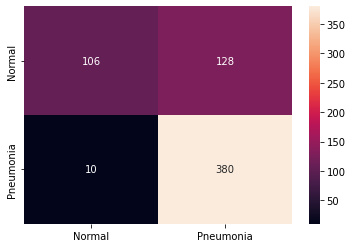

In [110]:
# Get prediction
pred = vgg_conv.predict(test_data, batch_size=16)
pred = np.argmax(pred, axis=-1)

# Original Labels
labels = np.argmax(test_labels, axis=-1)
from sklearn.metrics import classification_report
print(classification_report(labels, pred))

cm = confusion_matrix(labels, pred)
import seaborn as sns
sns.heatmap(cm, annot=True, fmt='g', xticklabels=['Normal', 'Pneumonia'], yticklabels=['Normal', 'Pneumonia'])